# Create UMAP of gene embeddings with scGPT

Most of this is pulled from the tutorials, but here is a proof-of-concept of creating a gene umap from scGPT

In [1]:
import copy
import json
import os
from pathlib import Path
import sys
import warnings

import torch
from anndata import AnnData
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import pandas as pd
import tqdm
import gseapy as gp

from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)

sys.path.insert(0, "../")
import scgpt as scg
from scgpt.tasks import GeneEmbedding
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.model import TransformerModel
from scgpt.preprocess import Preprocessor
from scgpt.utils import set_seed 

os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')

/home/chasty2/Documents/scFM_benchmarking/.venv/lib/python3.12/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/chasty2/Documents/scFM_benchmarking/.venv/lib/python3.12/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/chasty2/Documents/scFM_benchmarking/.venv/lib/python3.12/site-packages/scgpt/

In [2]:
# Set parameters
set_seed(42)
pad_token = "<pad>"
special_tokens = [pad_token, "<cls>", "<eoc>"]
n_hvg = 1200
n_bins = 51
mask_value = -1
pad_value = -2
n_input_bins = n_bins

## Load pre-trained scGPT blood model

In [4]:

model_dir = Path("../models/scGPT_bc")
model_config_file = model_dir / "args.json"
model_file = model_dir / "best_model.pt"
vocab_file = model_dir / "vocab.json"

vocab = GeneVocab.from_file(vocab_file)
for s in special_tokens:
    if s not in vocab:
        vocab.append_token(s)

# Retrieve model parameters from config files
with open(model_config_file, "r") as f:
    model_configs = json.load(f)
print(
    f"Resume model from {model_file}, the model args will override the "
    f"config {model_config_file}."
)
embsize = model_configs["embsize"]
nhead = model_configs["nheads"]
d_hid = model_configs["d_hid"]
nlayers = model_configs["nlayers"]
n_layers_cls = model_configs["n_layers_cls"]

gene2idx = vocab.get_stoi()

Resume model from ../models/scGPT_bc/best_model.pt, the model args will override the config ../models/scGPT_bc/args.json.


In [5]:
# Load parameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid,
    nlayers,
    vocab=vocab,
    pad_value=pad_value,
    n_input_bins=n_input_bins,
)

try:
    model.load_state_dict(torch.load(model_file))
    print(f"Loading all model params from {model_file}")
except:
    # only load params that are in the model and match the size
    model_dict = model.state_dict()
    pretrained_dict = torch.load(model_file)
    pretrained_dict = {
        k: v
        for k, v in pretrained_dict.items()
        if k in model_dict and v.shape == model_dict[k].shape
    }
    for k, v in pretrained_dict.items():
        print(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

model.to(device)

Loading params encoder.embedding.weight with shape torch.Size([36574, 512])
Loading params encoder.enc_norm.weight with shape torch.Size([512])
Loading params encoder.enc_norm.bias with shape torch.Size([512])
Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
Loading params value_encoder.linear1.bias with shape torch.Size([512])
Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
Loading params value_encoder.linear2.bias with shape torch.Size([512])
Loading params value_encoder.norm.weight with shape torch.Size([512])
Loading params value_encoder.norm.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.self_attn.out_proj.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.linear1.weight with shape torch.Size([512, 512])
Loading params transformer_encoder.layers.0.linear1.bias with 

TransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(36574, 512, padding_idx=36571)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.5, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-11): 12 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, el

## Load Immune Human Dataset

In [6]:
# Specify model path
data_dir = Path("../data")
adata = sc.read(
    str(data_dir / "Immune_ALL_human.h5ad"), cache=True
)  # 33506 × 12303
ori_batch_col = "batch"
adata.obs["celltype"] = adata.obs["final_annotation"].astype(str)
data_is_raw = False


In [7]:
# Preprocess the data following the scGPT data pre-processing pipeline
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=3,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=n_hvg,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=n_bins,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key="batch")

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - INFO - Binning data ...


## Retrieve scGPT's gene embeddings

In [8]:
# Retrieve the data-independent gene embeddings from scGPT
gene_ids = np.array([id for id in gene2idx.values()])
gene_embeddings = model.encoder(torch.tensor(gene_ids, dtype=torch.long).to(device))
gene_embeddings = gene_embeddings.detach().cpu().numpy()

In [12]:
len(gene_embeddings)


1173

In [9]:
# Filter on the intersection between the Immune Human HVGs found in the loaded dataset and scGPT's 30+K foundation model vocab
gene_embeddings = {gene: gene_embeddings[i] for i, gene in enumerate(gene2idx.keys()) if gene in adata.var.index.tolist()}
print('Retrieved gene embeddings for {} genes.'.format(len(gene_embeddings)))

Retrieved gene embeddings for 1173 genes.


In [ ]:
# Construct gene embedding network
# TODO: How is this calculated? cosine similarities?
# TODO: How do we update gene embeddings? Retrieve cell-type specific embeddings
embed = GeneEmbedding(gene_embeddings)

100%|██████████| 1173/1173 [00:00<00:00, 1462955.28it/s]


## Construct gene UMAP

In [14]:
# Perform Louvain clustering with desired resolution; here we specify resolution=2
# NOTE: this is where we depart from the tutorial
gdata = embed.get_adata(resolution=2)
# # Retrieve the gene clusters
# metagenes = embed.get_metagenes(gdata)

In [15]:
# Explore AnnData object
print(gdata.obs['leiden'].dtype)
print(gdata.obs['leiden'].unique())
print(gdata.obs['leiden'].value_counts())
print(gdata.X)
gdata

category
['5', '3', '0', '10', '9', ..., '8', '2', '7', '13', '12']
Length: 15
Categories (15, object): ['0', '1', '2', '3', ..., '11', '12', '13', '14']
leiden
0     178
1     141
2     128
3     107
4      93
5      83
6      77
7      67
8      61
9      59
10     57
11     44
12     38
13     24
14     16
Name: count, dtype: int64
[[-1.294346    0.16357721 -1.1277636  ... -0.2182254  -0.49278018
   0.49983156]
 [-1.6622987   1.7298526  -1.4106126  ... -0.37593752  0.44506472
  -1.0116625 ]
 [ 1.0077838  -0.68379974  0.47985855 ...  2.3564315   0.4869241
  -2.3588264 ]
 ...
 [ 0.9415226  -0.01734498 -2.0994334  ...  0.85039115  0.15421386
   2.528442  ]
 [ 1.250761   -0.64495623 -0.23676826 ...  0.9422393   1.4726967
  -0.693309  ]
 [ 1.2143009  -0.6784211  -2.0702324  ...  1.4746554  -1.7314457
  -0.50180846]]


AnnData object with n_obs × n_vars = 1173 × 512
    obs: 'leiden'
    uns: 'neighbors', 'leiden', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

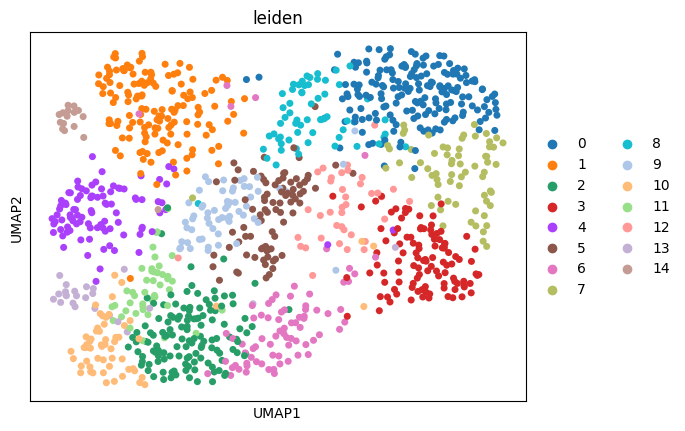

In [16]:
# Compute the neighbor graph on gene embeddings
sc.pp.neighbors(gdata, use_rep='X')

# Compute UMAP coordinates
sc.tl.umap(gdata)

# Plot UMAP
sc.pl.umap(gdata, color='leiden')


In [17]:

import plotly.express as px

# Create a dataframe with UMAP coords and gene names
umap_df = pd.DataFrame(
    gdata.obsm['X_umap'], 
    columns=['UMAP1', 'UMAP2'],
    index=gdata.obs.index
)
umap_df['leiden'] = gdata.obs['leiden'].values
umap_df['gene'] = gdata.obs.index

# Plot interactive UMAP
fig = px.scatter(
    umap_df, 
    x='UMAP1', 
    y='UMAP2', 
    color='leiden',
    hover_name='gene',
    title='Gene UMAP of Immune Human HVGs in loaded dataset and scGPT\'s vocab'
)
fig.show()

## Calculate Average Gene Embedding for a Given Cell Type

In [14]:
def get_celltype_embedding(adata, gdata, celltype, layer='X_normed'):
    """
    Compute average gene embedding for a cell type, weighted by expression.
    
    Parameters:
    - adata: cell AnnData with expression and celltype annotations
    - gdata: gene AnnData with embeddings in .X
    - celltype: string, the cell type to compute embedding for
    - layer: which layer to use for expression values
    """
    # Subset to cells of this type
    cells_mask = adata.obs['celltype'] == celltype

    if cells_mask.sum() == 0:
        raise ValueError(f"No cells found for celltype '{celltype}'. "
                        f"Available: {adata.obs['celltype'].unique().tolist()}")
    
    # Get expression matrix for this cell type
    if layer and layer in adata.layers:
        expr = adata[cells_mask].layers[layer]
    else:
        expr = adata[cells_mask].X
    
    # Mean expression per gene across cells of this type
    mean_expr = np.array(expr.mean(axis=0)).flatten()
    
    # Find genes that are in both adata and gdata
    common_genes = [g for g in adata.var_names if g in gdata.obs.index]
    
    # Get expression weights for common genes
    gene_idx_adata = [list(adata.var_names).index(g) for g in common_genes]
    weights = mean_expr[gene_idx_adata]
    
    # Normalize weights
    weights = weights / weights.sum()
    
    # Get embeddings for common genes
    gene_idx_gdata = [list(gdata.obs.index).index(g) for g in common_genes]
    embeddings = gdata.X[gene_idx_gdata]
    
    # Weighted average of gene embeddings
    celltype_embedding = np.average(embeddings, axis=0, weights=weights)
    
    return celltype_embedding



In [18]:
adata

AnnData object with n_obs × n_vars = 33506 × 1200
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'celltype'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg'
    obsm: 'bin_edges'
    layers: 'counts', 'X_normed', 'X_binned'

In [15]:
# Testing:
cd4_embedding = get_celltype_embedding(adata, gdata, 'CD4+ T cells')
cd4_embedding


array([ 0.071768  ,  0.6328272 ,  0.0818498 , -0.07451334, -0.20052646,
       -0.39142364, -0.25494614,  0.3214102 ,  0.13551131, -0.12647822,
        0.01283029,  0.0993356 ,  0.17035042, -0.32876557, -0.06996157,
        0.4374378 , -0.44094753,  0.3067588 , -0.14201304, -0.20909926,
        0.21768412, -0.1688155 , -0.2642786 ,  0.0588266 ,  0.06386534,
        0.26557598,  0.22701043,  0.35828987, -0.15624097,  0.5975445 ,
        0.00785281,  0.0480959 , -0.11318862,  0.0156092 ,  0.16962329,
       -0.2953183 ,  0.5096074 , -0.0590493 , -0.287402  ,  0.04747875,
        0.14672476,  0.2460696 ,  0.21104048,  0.405396  , -0.06944148,
        0.10908665,  0.16239406, -0.03242493, -0.20478767, -0.0655118 ,
        0.212271  , -0.0454638 , -0.1808388 ,  0.4178031 , -0.02152923,
        0.21755327,  0.14393157, -0.0816272 ,  0.28314176,  0.23121972,
        0.08360905, -0.0097421 , -0.01099561,  0.12880483, -0.06774087,
       -0.11873835,  0.07368133, -0.04131493, -0.17675726, -0.00

In [16]:
# Compute for all cell types
celltypes = adata.obs['celltype'].unique()
celltype_embeddings = {}

for ct in celltypes:
    celltype_embeddings[ct] = get_celltype_embedding(adata, gdata, ct)

# Create an AnnData of cell type embeddings
ct_matrix = np.vstack(list(celltype_embeddings.values()))
ct_adata = AnnData(
    X=ct_matrix,
    obs=pd.DataFrame(index=list(celltype_embeddings.keys()))
)


In [ ]:
# TODO: We want gene embeddings for a specific gene, within a specific cell type

# TODO: Split AnnData based on cell types into multiple AnnData objects